In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:02<00:00, 105MB/s]
100% 331M/331M [00:02<00:00, 129MB/s]


In [5]:
!unzip -qq utkface-new.zip

In [ ]:
!pip install wandb

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers , models , Sequential , optimizers ,applications

import cv2
import matplotlib.pyplot as plt
# import wandb
# from wandb.keras import (
#    WandbMetricsLogger,
#    WandbModelCheckpoint,
# )



In [ ]:
run = wandb.init(project="Age_Prediction")
config = wandb.config
wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models"),
]

wandb: Currently logged in as: mohamad-nematizadehhh. Use `wandb login --relogin` to force relogin


In [2]:
width = height = 128

In [3]:
imags = [] #X
ages = []  #Y
for image_name in os.listdir("UTKFace"):
  parts = image_name.split("_")
  age = int(parts[0])
  ages.append(age)

  image = cv2.imread("UTKFace/"+image_name)
  image = cv2.resize(image,(width,height))
  image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
  imags.append(image)

In [4]:
imags = pd.Series(imags, name="Images")
ages = pd.Series(ages , name="Ages")
df = pd.concat([imags,ages],axis=1)
df.head()

,Images,Ages
0,"[[[34, 31, 38], [47, 40, 47], [55, 45, 50], [6...",34
1,"[[[26, 18, 31], [24, 18, 28], [23, 18, 27], [2...",26
2,"[[[21, 21, 21], [19, 19, 19], [21, 21, 21], [2...",18
3,"[[[56, 32, 27], [45, 20, 15], [46, 18, 11], [5...",50
4,"[[[41, 31, 22], [40, 27, 19], [42, 29, 21], [4...",41


34


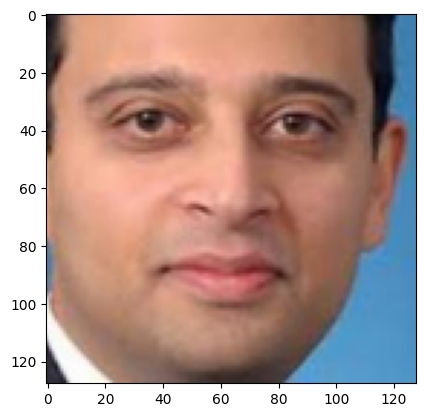

In [5]:
print(df["Ages"][0])
plt.imshow(df["Images"][0])
plt.show()

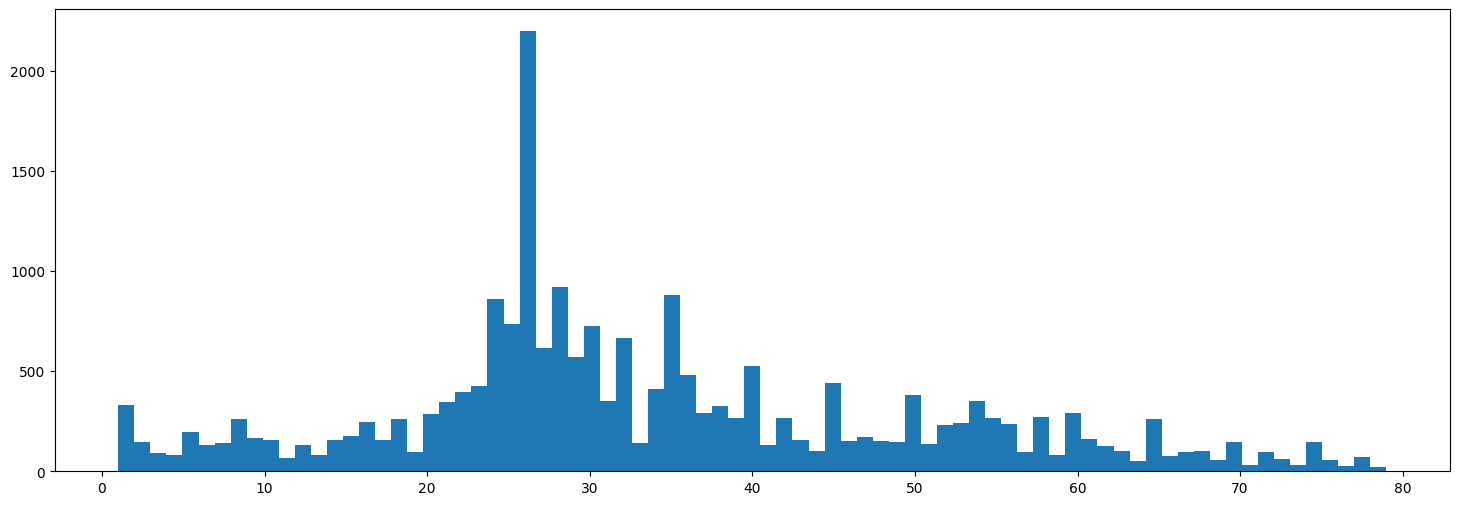

In [12]:
plt.figure(figsize=(18,6))
plt.hist(df["Ages"],bins=df["Ages"].max())
plt.show()

In [7]:
under_4 = df[df["Ages"] <= 4]
up_4 = df[df["Ages"] > 4]
under_4 = under_4.sample(frac=0.3)
df = pd.concat([under_4,up_4] , axis=0)
df = df[df["Ages"] < 80]

In [8]:
X = np.array(df["Images"].values.tolist())
Y = np.array(df["Ages"].values.tolist())


In [9]:
X.shape

(21518, 128, 128, 3)

In [10]:
X_train,X_validation , Y_train , Y_validation = train_test_split(X,Y,test_size=0.2)
print(X_train.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(17214, 128, 128, 3)
(4304, 128, 128, 3)
(17214,)
(4304,)


In [11]:
image_data_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,

)
train_data = image_data_generator.flow(
    X_train,
    Y_train,
    batch_size=32,
    shuffle=True
)

validation_data = image_data_generator.flow(
    X_validation,
    Y_validation,
    batch_size=16,
    shuffle=True
)

Creat Model


In [13]:
base_model = applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(width,height,3),
    pooling="avg"
)

9406464/9406464 [==============================] - 0s 0us/step


In [16]:
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [17]:
my_model = Sequential([
    base_model,
    layers.Dropout(0.5),
    layers.Dense(1,activation='relu'),
])


In [18]:
my_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 413441 (1.58 MB)
Non-trainable params: 1845824 (7.04 MB)
_________________________________________________________________


In [19]:
import tensorflow as tf

In [20]:
my_model.compile(
    loss= tf.keras.losses.mean_absolute_error,
    optimizer=tf.keras.optimizers.Adam(),
)

In [21]:
plt_model = my_model.fit(train_data, validation_data=validation_data, epochs=20)

Epoch 1/20
538/538 [==============================] - 31s 32ms/step - loss: 10.2877 - val_loss: 45.9213
Epoch 2/20
538/538 [==============================] - 17s 31ms/step - loss: 8.2979 - val_loss: 27.3419
Epoch 3/20
538/538 [==============================] - 16s 30ms/step - loss: 8.0945 - val_loss: 17.6816
Epoch 4/20
538/538 [==============================] - 18s 33ms/step - loss: 7.8782 - val_loss: 13.7874
Epoch 5/20
538/538 [==============================] - 19s 35ms/step - loss: 7.7468 - val_loss: 13.3012
Epoch 6/20
538/538 [==============================] - 16s 31ms/step - loss: 7.5856 - val_loss: 12.9047
Epoch 7/20
538/538 [==============================] - 15s 29ms/step - loss: 7.5993 - val_loss: 13.7491
Epoch 8/20
538/538 [==============================] - 18s 34ms/step - loss: 7.5214 - val_loss: 13.1139
Epoch 9/20
538/538 [==============================] - 17s 31ms/step - loss: 7.4482 - val_loss: 10.2106
Epoch 10/20
538/538 [==============================] - 15s 29ms/step - l

In [24]:
my_model.save('/content/drive/MyDrive/kaggle/Age-prediction.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 23ms/step
[[15.2223425]]


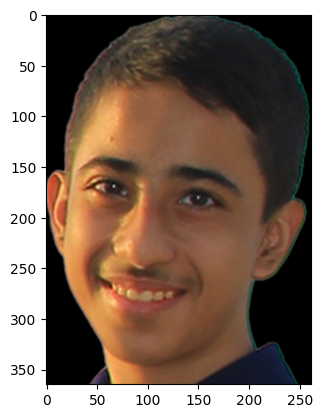

In [28]:
image = cv2.imread("/content/about.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
image = cv2.resize(image,(width,height))
image = image / 255.0
image = image[np.newaxis, ...]

result = my_model.predict(image)
print(result)
plt.show()